In [1]:
# Cell 1: Setup and Imports
import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, split, explode, year, log, coalesce, to_date, lit, concat, rand, mean
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType



In [2]:
# Configure logging
logging.basicConfig(
    filename='eda_pipeline.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
console = logging.StreamHandler()
console.setLevel(logging.INFO)
console.setFormatter(logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'))
logging.getLogger().addHandler(console)

# Stop any existing Spark sessions
spark = SparkSession.getActiveSession()
if spark:
    spark.stop()
    logging.info("Stopped existing Spark session")

# Initialize Spark session
os.environ["PYSPARK_PYTHON"] = os.path.abspath(".venv/Scripts/python.exe")

spark = SparkSession.builder \
    .appName("CostAwareRecommendation") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.pyspark.python", os.environ["PYSPARK_PYTHON"]) \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.port", "25334") \
    .config("spark.ui.showConsoleProgress", "false") \
    .config("spark.driver.extraJavaOptions", "-Xss4m") \
    .config("spark.executor.extraJavaOptions", "-Xss4m") \
    .getOrCreate()
logging.info(f"Created Spark session: {spark.sparkContext.uiWebUrl}")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

logging.info(
    "Spark session initialized, logging configured, and plotting style set.")

2025-08-04 13:08:05,704 - INFO - Created Spark session: http://127.0.0.1:4040
2025-08-04 13:08:05,709 - INFO - Spark session initialized, logging configured, and plotting style set.


In [3]:
def load_data_and_budgets():
    try:
        # Define schemas
        ratings_schema = StructType([
            StructField("userId", IntegerType(), False),
            StructField("movieId", IntegerType(), False),
            StructField("rating", FloatType(), False),
            StructField("timestamp", IntegerType(), False)
        ])
        movies_schema = StructType([
            StructField("movieId", IntegerType(), False),
            StructField("title", StringType(), False),
            StructField("genres", StringType(), True)
        ])
        links_schema = StructType([
            StructField("movieId", IntegerType(), False),
            StructField("imdbId", StringType(), True),
            StructField("tmdbId", StringType(), True)
        ])
        title_basics_schema = StructType([
            StructField("tconst", StringType(), False),
            StructField("titleType", StringType(), True),
            StructField("primaryTitle", StringType(), True),
            StructField("originalTitle", StringType(), True),
            StructField("isAdult", StringType(), True),
            StructField("startYear", StringType(), True),
            StructField("endYear", StringType(), True),
            StructField("runtimeMinutes", StringType(), True),
            StructField("genres", StringType(), True)
        ])

        # Load MovieLens data
        ratings_df = spark.read.schema(ratings_schema).csv(
            "ml-25m/ratings.csv", header=True)
        movies_df = spark.read.schema(movies_schema).csv(
            "ml-25m/movies.csv", header=True)
        links_df = spark.read.schema(links_schema).csv(
            "ml-25m/links.csv", header=True)

        # Load IMDb data
        basics_df = spark.read.schema(title_basics_schema).option(
            "delimiter", "\t").csv("imdb/title.basics.tsv.gz", header=True)

        # Check if budgets CSV exists
        budgets_path = os.path.abspath("tmdb_budgets.csv")

        budgets_df = spark.read.csv(
            budgets_path, header=True, inferSchema=True)

        # Format imdbId to match tconst (add 'tt' prefix)
        links_df = links_df.withColumn(
            "imdbId", concat(lit("tt"), col("imdbId")))

        logging.info("Loaded all datasets and budgets.")
        return ratings_df, movies_df, links_df, basics_df, budgets_df
    except Exception as e:
        logging.error(f"Failed to load data and budgets: {str(e)}")
        raise

ratings_df, movies_df, links_df, basics_df, budgets_df = load_data_and_budgets()


2025-08-04 13:08:11,446 - INFO - Loaded all datasets and budgets.


In [12]:
print([df.show(10) for df in [ratings_df, movies_df, links_df, basics_df, budgets_df]])

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      1|   4.0|1225734739|
|     1|    110|   4.0|1225865086|
|     1|    158|   4.0|1225733503|
|     1|    260|   4.5|1225735204|
|     1|    356|   5.0|1225735119|
|     1|    381|   3.5|1225734105|
|     1|    596|   4.0|1225733524|
|     1|   1036|   5.0|1225735626|
|     1|   1049|   3.0|1225734079|
|     1|   1066|   4.0|1225736961|
+------+-------+------+----------+
only showing top 10 rows
+-------+--------------------+--------------------+---------+------------+
|movieId|               title|              genres|   budget|release_date|
+-------+--------------------+--------------------+---------+------------+
| 167420|  Master i Margarita|       Drama,Fantasy|      0.0|  1994-06-06|
|   3751|         Chicken Run|Adventure,Animati...|    4.5E7|  2000-06-23|
|   5791|               Frida|Biography,Drama,R...|    1.2E7|  2002-08-29|
|  33493|Star Wars: Episod...|Actio

[None, None, None, None, None]

In [4]:
import time

def preprocess_data(ratings_df, movies_df, links_df, basics_df, budgets_df):
    try:
        # Log start of preprocessing
        logging.info(f"Starting preprocess_data at {time.time()}")

        # Validate input DataFrames
        logging.info("Validating input DataFrames...")
        for df, name in [(ratings_df, "ratings_df"), (movies_df, "movies_df"),
                         (links_df, "links_df"), (basics_df, "basics_df"),
                         (budgets_df, "budgets_df")]:
            if df is None:
                raise ValueError(f"{name} is None")
            df_count = df.count()
            logging.info(f"{name} has {df_count} rows")

        # Clean startYear by replacing '\N' with null in basics_df
        basics_df = basics_df.withColumn(
            "startYear",
            when(col("startYear") != "\\N", col("startYear")).otherwise(None)
        )

        # Merge datasets
        movies_df = (
            movies_df
            .join(links_df, "movieId", "inner")
            .join(
                basics_df.select(
                    col("tconst"),
                    col("primaryTitle"),
                    col("startYear"),
                    col("genres").alias("basics_genres")
                ),
                col("imdbId") == col("tconst"),
                "left"
            )
            .join(budgets_df, "movieId", "left")
            .filter(
                (col("startYear").isNotNull() & col("startYear").cast("int").between(2000, 2025)) |
                (col("release_date").isNotNull() & to_date(
                    col("release_date")).cast("string").like("20[0-2][0-5]%"))
            )
            .select(
                col("movieId"),
                col("primaryTitle").alias("title"),
                coalesce(col("basics_genres"), col("genres")).alias("genres"),
                col("budget").cast("float"),
                to_date(col("release_date")).alias("release_date")
            )
        )

        logging.info(
            f"Preprocessed {ratings_df.count()} ratings and {movies_df.count()} movies.")
        return ratings_df, movies_df
    except Exception as e:
        logging.error(f"Failed to preprocess data: {str(e)}")
        raise


# Call the function
ratings_df, movies_df = preprocess_data(
    ratings_df, movies_df, links_df, basics_df, budgets_df)

2025-08-04 13:08:13,465 - INFO - Starting preprocess_data at 1754330893.4653993
2025-08-04 13:08:13,470 - INFO - Validating input DataFrames...
2025-08-04 13:08:15,833 - INFO - ratings_df has 33832162 rows
2025-08-04 13:08:15,998 - INFO - movies_df has 86537 rows
2025-08-04 13:08:16,161 - INFO - links_df has 86537 rows
2025-08-04 13:08:22,540 - INFO - basics_df has 11771649 rows
2025-08-04 13:08:22,661 - INFO - budgets_df has 85305 rows
2025-08-04 13:08:50,479 - INFO - Preprocessed 33832162 ratings and 50888 movies.


In [15]:
print("ratings_df", ratings_df.show(10))
print("movies_df", movies_df.show(10))

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      1|   4.0|1225734739|
|     1|    110|   4.0|1225865086|
|     1|    158|   4.0|1225733503|
|     1|    260|   4.5|1225735204|
|     1|    356|   5.0|1225735119|
|     1|    381|   3.5|1225734105|
|     1|    596|   4.0|1225733524|
|     1|   1036|   5.0|1225735626|
|     1|   1049|   3.0|1225734079|
|     1|   1066|   4.0|1225736961|
+------+-------+------+----------+
only showing top 10 rows
ratings_df None
+-------+--------------------+--------------------+---------+------------+
|movieId|               title|              genres|   budget|release_date|
+-------+--------------------+--------------------+---------+------------+
| 167420|  Master i Margarita|       Drama,Fantasy|      0.0|  1994-06-06|
|   3751|         Chicken Run|Adventure,Animati...|    4.5E7|  2000-06-23|
|   5791|               Frida|Biography,Drama,R...|    1.2E7|  2002-08-29|
|  33493|Star Wars:

In [9]:
# Cell 3: Column Descriptions
def describe_columns():
    try:
        descriptions = {
            "ratings_df": {
                "userId": "Unique identifier for a user (integer).",
                "movieId": "Unique identifier for a movie (integer), links to movies_df.",
                "rating": "User rating for the movie (float, 0.5 to 5.0, in 0.5 increments).",
                "timestamp": "Unix timestamp of when the rating was given (integer, seconds since 1970-01-01)."
            },
            "merged_df": {
                "movieId": "Unique identifier for a movie (integer), links to ratings_df.",
                "title": "Movie title (string, sourced from IMDb primaryTitle).",
                "genres": "Pipe-separated list of genres (string, e.g., 'Action|Drama').",
                "budget": "Production budget in USD (float, from TMDb, may be missing).",
                "release_year": "Year of movie release (integer, 2000–2020, from TMDb release_date)."
            }
        }

        # Log descriptions
        for df_name, cols in descriptions.items():
            logging.info(f"Column descriptions for {df_name}:")
            for col_name, desc in cols.items():
                logging.info(f"  {col_name}: {desc}")

        # Save to file for dissertation
        with open("eda_plots/column_descriptions.txt", "w") as f:
            for df_name, cols in descriptions.items():
                f.write(f"{df_name}:\n")
                for col_name, desc in cols.items():
                    f.write(f"  {col_name}: {desc}\n")

        logging.info(
            "Column descriptions saved to eda_plots/column_descriptions.txt")
    except Exception as e:
        logging.error(f"Failed to describe columns: {str(e)}")
        raise


describe_columns()

In [13]:
# Cell 4: Data Size
def analyze_data_size(ratings_df, movies_df):
    try:
        # Count rows and columns
        ratings_rows, ratings_cols = ratings_df.count(), len(ratings_df.columns)
        movies_rows, movies_cols = movies_df.count(), len(movies_df.columns)

        # Estimate memory usage (approximate)
        ratings_size_mb = (ratings_rows * ratings_cols * 8) / \
            (1024 ** 2)  # Assuming 8 bytes per cell
        movies_size_mb = (movies_rows * movies_cols * 8) / (1024 ** 2)

        # Log results
        logging.info(
            f"ratings_df: {ratings_rows} rows, {ratings_cols} columns, ~{ratings_size_mb:.2f} MB")
        logging.info(
            f"movies_df: {movies_rows} rows, {movies_cols} columns, ~{movies_size_mb:.2f} MB")

        # Save to file
        with open("eda_plots/data_size.txt", "w") as f:
            f.write(
                f"ratings_df: {ratings_rows} rows, {ratings_cols} columns, ~{ratings_size_mb:.2f} MB\n")
            f.write(
                f"movies_df: {movies_rows} rows, {movies_cols} columns, ~{movies_size_mb:.2f} MB\n")

        logging.info("Data size saved to eda_plots/data_size.txt")
    except Exception as e:
        logging.error(f"Failed to analyze data size: {str(e)}")
        raise


analyze_data_size(ratings_df, movies_df)

2025-08-03 17:13:05,110 - INFO - ratings_df: 33832162 rows, 4 columns, ~1032.48 MB
2025-08-03 17:13:05,110 - INFO - movies_df: 50888 rows, 5 columns, ~1.94 MB
2025-08-03 17:13:05,119 - INFO - Data size saved to eda_plots/data_size.txt


In [17]:
# Cell 5: Distributions and Normality Tests
def analyze_distributions(ratings_df, movies_df):
    try:
        # Convert to Pandas for plotting and normality tests
        ratings_pd = ratings_df.select("rating").toPandas()
        movies_pd = movies_df.select(
            col("budget"),
            year("release_date").alias("release_year")
        ).toPandas()

        # Summary statistics
        ratings_stats = ratings_df.select("rating").describe().toPandas()
        budget_stats = movies_df.filter(col("budget") > 0).select(
            "budget").describe().toPandas()
        year_stats = movies_df.select(year("release_date").alias("release year")).describe().toPandas()

        # Plot histograms
        plt.figure()
        sns.histplot(ratings_pd["rating"], bins=10, kde=True)
        plt.title("Distribution of Ratings")
        plt.xlabel("Rating")
        plt.ylabel("Count")
        plt.savefig("eda_plots/ratings_histogram.png")
        plt.close()

        plt.figure()
        sns.histplot(movies_pd[movies_pd["budget"] > 0]
                     ["budget"], bins=50, kde=True)
        plt.title("Distribution of Non-Zero Budgets")
        plt.xlabel("Budget (USD)")
        plt.ylabel("Count")
        plt.savefig("eda_plots/budget_histogram.png")
        plt.close()

        plt.figure()
        sns.histplot(movies_pd["release_year"], bins=21, kde=True)
        plt.title("Distribution of Release Years (2000–2020)")
        plt.xlabel("Release Year")
        plt.ylabel("Count")
        plt.savefig("eda_plots/release_year_histogram.png")
        plt.close()

        # Normality tests (Shapiro-Wilk on sample due to large data)
        rating_sample = ratings_pd["rating"].sample(
            n=min(5000, len(ratings_pd)), random_state=42)
        budget_sample = movies_pd[movies_pd["budget"] > 0]["budget"].sample(
            n=min(5000, len(movies_pd[movies_pd["budget"] > 0])), random_state=42)
        year_sample = movies_pd["release_year"].dropna().sample(
            n=min(5000, len(movies_pd)), random_state=42)

        rating_stat, rating_p = shapiro(rating_sample)
        # Log-transform budget for normality test
        budget_stat, budget_p = shapiro(np.log1p(budget_sample))
        year_stat, year_p = shapiro(year_sample)

        # Log results
        logging.info("Rating distribution stats:\n" +
                     ratings_stats.to_string())
        logging.info(
            f"Rating normality test: W={rating_stat:.4f}, p={rating_p:.4f} {'(not normal)' if rating_p < 0.05 else '(normal)'}")
        logging.info("Budget distribution stats:\n" + budget_stats.to_string())
        logging.info(
            f"Budget (log-transformed) normality test: W={budget_stat:.4f}, p={budget_p:.4f} {'(not normal)' if budget_p < 0.05 else '(normal)'}")
        logging.info("Release year distribution stats:\n" +
                     year_stats.to_string())
        logging.info(
            f"Release year normality test: W={year_stat:.4f}, p={year_p:.4f} {'(not normal)' if year_p < 0.05 else '(normal)'}")

        # Save stats
        with open("eda_plots/distribution_stats.txt", "w") as f:
            f.write("Rating distribution stats:\n" +
                    ratings_stats.to_string() + "\n\n")
            f.write(
                f"Rating normality test: W={rating_stat:.4f}, p={rating_p:.4f} {'(not normal)' if rating_p < 0.05 else '(normal)'}\n")
            f.write("Budget distribution stats:\n" +
                    budget_stats.to_string() + "\n\n")
            f.write(
                f"Budget (log-transformed) normality test: W={budget_stat:.4f}, p={budget_p:.4f} {'(not normal)' if budget_p < 0.05 else '(normal)'}\n")
            f.write("Release year distribution stats:\n" +
                    year_stats.to_string() + "\n\n")
            f.write(
                f"Release year normality test: W={year_stat:.4f}, p={year_p:.4f} {'(not normal)' if year_p < 0.05 else '(normal)'}\n")

        logging.info(
            "Distributions and normality tests saved to eda_plots/distribution_stats.txt")
    except Exception as e:
        logging.error(f"Failed to analyze distributions: {str(e)}")
        raise


analyze_distributions(ratings_df, movies_df)

2025-08-03 17:49:27,563 - INFO - Rating distribution stats:
  summary              rating
0   count            33832162
1    mean    3.54254040873888
2  stddev  1.0639586178664844
3     min                 0.5
4     max                 5.0
2025-08-03 17:49:27,568 - INFO - Rating normality test: W=0.9294, p=0.0000 (not normal)
2025-08-03 17:49:27,568 - INFO - Budget distribution stats:
  summary                budget
0   count                 10367
1    mean  2.0266758294781517E7
2  stddev    3.73178623947418E7
3     min                   1.0
4     max               4.654E8
2025-08-03 17:49:27,578 - INFO - Budget (log-transformed) normality test: W=0.8670, p=0.0000 (not normal)
2025-08-03 17:49:27,582 - INFO - Release year distribution stats:
  summary       release year
0   count              50017
1    mean  2012.900493832097
2  stddev  6.124272447228714
3     min               1951
4     max               2025
2025-08-03 17:49:27,582 - INFO - Release year normality test: W=0.9598, p=

In [19]:
# Cell 6: Sample Data
def sample_data(ratings_df, movies_df):
    try:
        # Collect 5 random samples
        ratings_sample = ratings_df.orderBy(rand()).limit(5).toPandas()
        movies_sample = movies_df.orderBy(rand()).limit(5).toPandas()

        # Log samples
        logging.info("Ratings sample:\n" + ratings_sample.to_string())
        logging.info("Movies sample:\n" + movies_sample.to_string())

        # Save to file
        with open("eda_plots/data_samples.txt", "w") as f:
            f.write("Ratings sample:\n" + ratings_sample.to_string() + "\n\n")
            f.write("Movies sample:\n" + movies_sample.to_string() + "\n")

        logging.info("Data samples saved to eda_plots/data_samples.txt")
    except Exception as e:
        logging.error(f"Failed to sample data: {str(e)}")
        raise


sample_data(ratings_df, movies_df)

2025-08-03 17:53:45,835 - INFO - Ratings sample:
   userId  movieId  rating   timestamp
0  277636   177765     4.0  1685470107
1  226948        5     4.0   982427965
2  239415    33834     3.5  1633713947
3  145639     1474     4.0   884338404
4   27069     4963     3.5  1094007447
2025-08-03 17:53:45,843 - INFO - Movies sample:
   movieId                                     title                         genres      budget release_date
0     5402  Nijinsky: The Diaries of Vaslav Nijinsky    Biography,Documentary,Music         0.0   2002-04-25
1   277158                                Alex's War  Biography,Documentary,History         0.0   2022-07-29
2   260855                              Naked Poison                 Crime,Thriller         0.0   2000-09-23
3    94352                              Bride Flight                  Drama,Romance   6400000.0   2008-10-15
4   185001                             I Feel Pretty                 Comedy,Romance  32000000.0   2018-04-19
2025-08-03 17:5

In [13]:
from pyspark.sql.functions import col, when, count, mean, year, to_date, explode, split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import logging
import os


def additional_eda(ratings_df, movies_df):
    try:
        os.makedirs("eda_plots", exist_ok=True)

        # Missing value analysis
        ratings_missing = ratings_df.select(
            [count(when(col(c).isNull(), c)).alias(c)
             for c in ratings_df.columns]
        ).toPandas()

        movies_missing = movies_df.select(
            [count(when(col(c).isNull(), c)).alias(c)
             for c in movies_df.columns]
        ).toPandas()

        # Unique counts
        unique_users = ratings_df.select("userId").distinct().count()
        unique_movies_ratings = ratings_df.select("movieId").distinct().count()
        unique_movies = movies_df.select("movieId").distinct().count()

        # Genre distribution (Top 20)
        genre_df = movies_df.select(
            explode(split("genres", "\\|")).alias("genre")
        ).groupBy("genre").count().orderBy(col("count").desc()).limit(20).toPandas()

        # Budget vs. average rating (non-zero only)
        avg_rating_df = ratings_df.groupBy("movieId").agg(
            mean("rating").alias("avg_rating"))
        corr_df = movies_df.join(avg_rating_df, "movieId", "inner") \
            .filter(col("budget") > 0) \
            .select("budget", "avg_rating") \
            .toPandas()
        correlation = corr_df["budget"].corr(corr_df["avg_rating"])

        # Ratings by year (2000–2025)
        ratings_by_year = ratings_df.join(
            movies_df.select("movieId", year(
                to_date("release_date")).alias("release_year")),
            "movieId"
        ).filter((col("release_year") >= 2000) & (col("release_year") <= 2025)) \
         .groupBy("release_year") \
         .agg(count("rating").alias("rating_count"), mean("rating").alias("avg_rating")) \
         .toPandas()

        # Budgets by year (2000–2025, non-zero)
        budgets_by_year = movies_df.filter(
            (col("budget") > 0) &
            (year(to_date("release_date")) >= 2000) &
            (year(to_date("release_date")) <= 2025)
        ).select(
            year(to_date("release_date")).alias("release_year"), "budget"
        ).groupBy("release_year").agg(mean("budget").alias("avg_budget")).toPandas()

        # Release year distribution (2000–2025)
        release_year_df = movies_df.select(
            year(to_date("release_date")).alias("release_year")
        ).filter((col("release_year") >= 2000) & (col("release_year") <= 2025)) \
         .groupBy("release_year").count().toPandas()

        # Plot genre distribution (Top 20)
        plt.figure()
        sns.barplot(x="count", y="genre", data=genre_df)
        plt.title("Top 20 Movie Genres")
        plt.xlabel("Count")
        plt.ylabel("Genre")
        plt.tight_layout()
        plt.savefig("eda_plots/genre_distribution.png")
        plt.close()

        # Budget vs. average rating
        plt.figure()
        sns.scatterplot(x="budget", y="avg_rating", data=corr_df)
        plt.title(
            f"Budget vs. Average Rating (Correlation: {correlation:.2f})")
        plt.xlabel("Budget (USD)")
        plt.ylabel("Average Rating")
        plt.tight_layout()
        plt.savefig("eda_plots/budget_vs_rating_scatter.png")
        plt.close()

        # Ratings count by release year
        plt.figure()
        sns.lineplot(x="release_year", y="rating_count", data=ratings_by_year)
        plt.title("Ratings Count by Release Year (2000–2025)")
        plt.xlabel("Release Year")
        plt.ylabel("Rating Count")
        plt.tight_layout()
        plt.savefig("eda_plots/ratings_by_year.png")
        plt.close()

        # Average budget by year
        plt.figure()
        sns.lineplot(x="release_year", y="avg_budget", data=budgets_by_year)
        plt.title("Average Budget by Release Year (2000–2025)")
        plt.xlabel("Release Year")
        plt.ylabel("Average Budget (USD)")
        plt.tight_layout()
        plt.savefig("eda_plots/budgets_by_year.png")
        plt.close()

        # Release year distribution
        plt.figure()
        sns.barplot(x="release_year", y="count", data=release_year_df)
        plt.title("Movie Release Year Distribution (2000–2025)")
        plt.xlabel("Release Year")
        plt.ylabel("Movie Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig("eda_plots/release_year_distribution.png")
        plt.close()

        # Logging
        logging.info("Missing values in ratings_df:\n" +
                     ratings_missing.to_string())
        logging.info("Missing values in movies_df:\n" +
                     movies_missing.to_string())
        logging.info(
            f"Unique users: {unique_users}, Unique movies (ratings): {unique_movies_ratings}, Unique movies (metadata): {unique_movies}")
        logging.info(
            f"Budget vs. average rating correlation: {correlation:.2f}")
        logging.info("Genre distribution:\n" + genre_df.to_string())
        logging.info("Ratings by year:\n" + ratings_by_year.to_string())
        logging.info("Budgets by year:\n" + budgets_by_year.to_string())
        logging.info("Release year distribution:\n" +
                     release_year_df.to_string())

        # Save to text file
        with open("eda_plots/additional_eda.txt", "w") as f:
            f.write("Missing values in ratings_df:\n" +
                    ratings_missing.to_string() + "\n\n")
            f.write("Missing values in movies_df:\n" +
                    movies_missing.to_string() + "\n\n")
            f.write(
                f"Unique users: {unique_users}\nUnique movies (ratings): {unique_movies_ratings}\nUnique movies (metadata): {unique_movies}\n\n")
            f.write(
                f"Budget vs. average rating correlation: {correlation:.2f}\n\n")
            f.write("Genre distribution:\n" + genre_df.to_string() + "\n\n")
            f.write("Ratings by year:\n" +
                    ratings_by_year.to_string() + "\n\n")
            f.write("Budgets by year:\n" +
                    budgets_by_year.to_string() + "\n\n")
            f.write("Release year distribution:\n" +
                    release_year_df.to_string() + "\n")

        logging.info("EDA outputs saved in 'eda_plots' folder.")

    except Exception as e:
        logging.error(f"Failed to perform additional EDA: {str(e)}")
        raise


additional_eda(ratings_df, movies_df)

2025-08-04 13:39:27,320 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-04 13:39:27,335 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-04 13:39:27,766 - INFO - Missing values in ratings_df:
   userId  movieId  rating  timestamp
0       0        0       0          0
2025-08-04 13:39:27,769 - INFO - Missing values in movies_df:
   movieId  title  genres  budget  release_date
0        0      0       0     842           871
2025-08-04 13:39:27,770 - INFO - Unique users: 330975, Unique movies (ratings): 83239, Unique movies (metadata): 50888
2025-08-04 13:39:27,770 - INFO - Budget vs. average rating correlation: 0.09
2025-08-04 13:39:27,770 - INFO - Genre distribution:
        

In [8]:
# Genre distribution (top 20) using movies_df
genre_df = movies_df.select(
    explode(split("genres", "\\|")).alias("genre")
).groupBy("genre").count().orderBy("count", ascending=False).limit(10).toPandas()

# Plot top 20 genres
plt.figure(figsize=(10, 8))
sns.barplot(x="count", y="genre", data=genre_df)
plt.title("Top 10 Movie Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.savefig("eda_plots/genre_distribution.png")
plt.close()

# Year-wise trend of top genres (2000–2025)
top_10_genres = genre_df["genre"].tolist()

genre_year_df = movies_df.select(
    explode(split("genres", "\\|")).alias("genre"),
    year(to_date("release_date")).alias("release_year")
).filter(
    (col("release_year").between(2000, 2025)) &
    (col("genre").isin(top_10_genres))
).groupBy("release_year", "genre").count().toPandas()

# Plot year-wise trend
plt.figure(figsize=(12, 7))
sns.lineplot(data=genre_year_df, x="release_year", y="count", hue="genre", marker="o")
plt.title("Year-wise Trend of Top 20 Genres (2000–2025)")
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("eda_plots/genre_trend_by_year.png")
plt.close()

logging.info("Year-wise genre trend saved to eda_plots/genre_trend_by_year.png")


2025-08-04 13:20:59,016 - INFO - Year-wise genre trend saved to eda_plots/genre_trend_by_year.png


In [11]:
  # Budget vs. average rating (non-zero only)
avg_rating_df = ratings_df.groupBy("movieId").agg(
    mean("rating").alias("avg_rating"))
corr_df = movies_df.join(avg_rating_df, "movieId", "inner") \
    .filter(col("budget") > 0) \
    .select("budget", "avg_rating") \
    .toPandas()

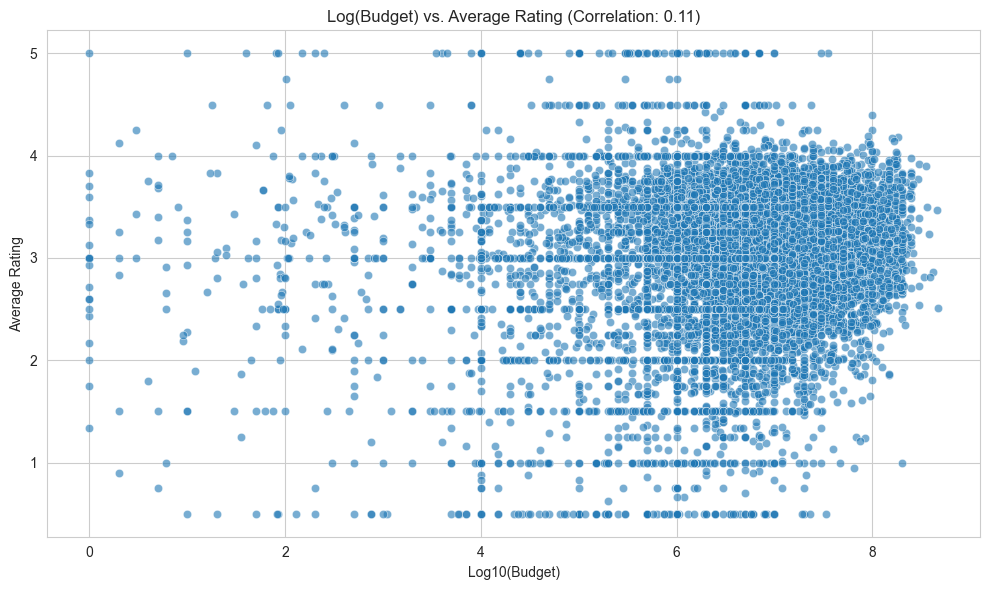

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with zero or negative budget (can't take log of those)
corr_df_nonzero = corr_df[corr_df["budget"] > 0].copy()
corr_df_nonzero["log_budget"] = np.log10(corr_df_nonzero["budget"])

# Calculate new correlation
log_corr = corr_df_nonzero["log_budget"].corr(corr_df_nonzero["avg_rating"])

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="log_budget", y="avg_rating",
                data=corr_df_nonzero, alpha=0.6)
plt.title(f"Log(Budget) vs. Average Rating (Correlation: {log_corr:.2f})")
plt.xlabel("Log10(Budget)")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.savefig("eda_plots/log_budget_vs_rating.png")
plt.show()

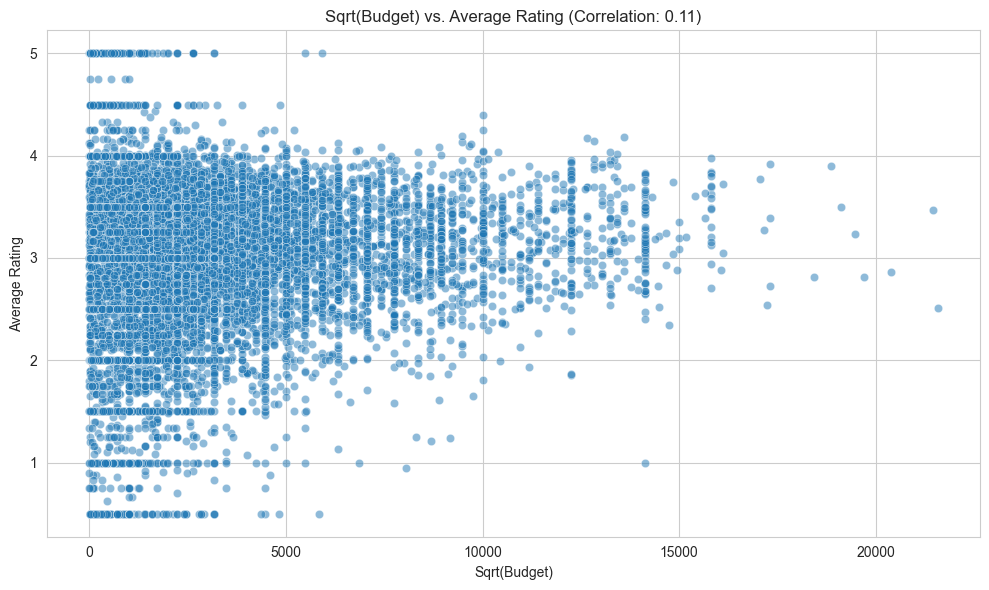

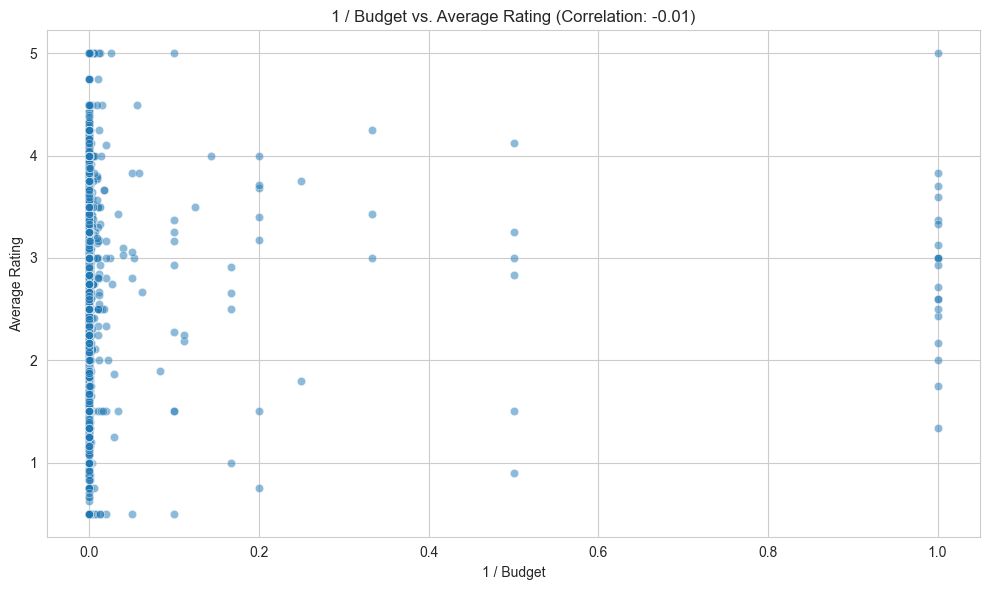

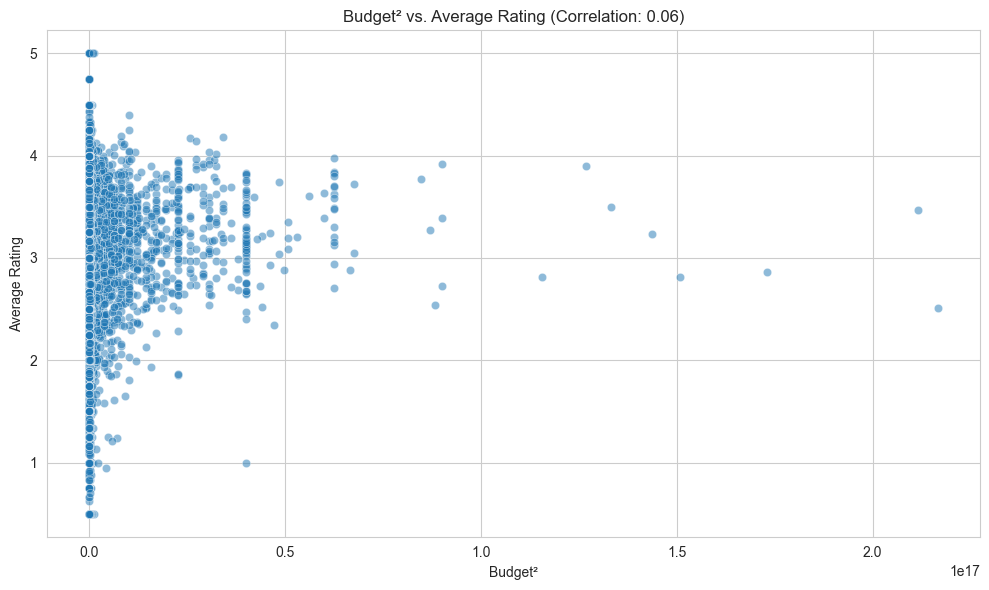

sqrt_budget: Correlation with rating = 0.1092
inv_budget: Correlation with rating = -0.0119
poly2_budget: Correlation with rating = 0.0592


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume corr_df_nonzero already exists and budget > 0
# Drop or filter non-positive budgets if necessary
corr_df_nonzero = corr_df[corr_df["budget"] > 0].copy()
budget = corr_df_nonzero["budget"]
rating = corr_df_nonzero["avg_rating"]

# Prepare transformed variables
corr_df_nonzero["sqrt_budget"] = np.sqrt(budget)
corr_df_nonzero["inv_budget"] = 1 / budget
corr_df_nonzero["poly2_budget"] = budget**2

# Compute correlations
correlations = {
    "sqrt_budget": corr_df_nonzero["sqrt_budget"].corr(rating),
    "inv_budget": corr_df_nonzero["inv_budget"].corr(rating),
    "poly2_budget": corr_df_nonzero["poly2_budget"].corr(rating)
}

# Plotting function


def plot_transformed(x_col, title_suffix, corr_val):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x_col, y="avg_rating", data=corr_df_nonzero, alpha=0.5)
    plt.title(f"{title_suffix} vs. Average Rating (Correlation: {corr_val:.2f})")
    plt.xlabel(title_suffix)
    plt.ylabel("Average Rating")
    plt.tight_layout()
    plt.savefig(f"eda_plots/{x_col}_vs_rating.png")
    plt.show()


# Generate the plots
plot_transformed("sqrt_budget", "Sqrt(Budget)", correlations["sqrt_budget"])
plot_transformed("inv_budget", "1 / Budget", correlations["inv_budget"])
plot_transformed("poly2_budget", "Budget²", correlations["poly2_budget"])

# Print summary
for key, val in correlations.items():
    print(f"{key}: Correlation with rating = {val:.4f}")

In [7]:
# Cell 8: Clean Up
def cleanup():
    try:
        spark.stop()
        logging.info("Spark session closed.")
    except Exception as e:
        logging.error(f"Cleanup failed: {str(e)}")
        raise


cleanup()

2025-08-03 19:48:00,360 - INFO - Spark session closed.
